# Job Analyzer Pipeline

This notebook contains the pipeline for processing and analyzing job postings data, including text preprocessing, entity extraction, and uploading data to a Weaviate instance.

## Overview

The main steps involved in this notebook are:

1. Load the job postings dataset and necessary libraries.
2. Set up the environment variables for OpenAI API key and Weaviate credentials.
3. Define a function to extract entities (products, organizations, and others) from job descriptions using spaCy.
4. Explore the dataset and analyze the length of job descriptions.
5. Preprocess the job postings data by extracting entities and generating text embeddings using OpenAI's text-embedding model.
6. Connect to a Weaviate instance and create a schema for the job postings data.
7. Upload the preprocessed job postings data to the Weaviate instance.
8. Download embedding from Weaviate and perform some clustering visualization using t-SNE.
9. Test some query's using Weaviates generative search.
10. Save vector imbedding with uuid's from weaviate for custom HNSW later.

## Usage

1. Make sure you have the required dependencies installed (`pandas`, `weaviate`, `openai`, `spacy`, `tqdm`, etc.).
2. Update the file paths and environment variables with your OpenAI API key and Weaviate credentials.
3. Run the notebook cells in order to preprocess the job postings data and upload it to a Weaviate instance.

## Dependencies

- `pandas`: For loading and manipulating the job postings dataset.
- `weaviate`: For interacting with the Weaviate instance.
- `openai`: For generating text embeddings using OpenAI's text-embedding model.
- `spacy`: For text preprocessing and entity extraction.
- `tqdm`: For displaying progress bars during data processing.

## Notes

- The notebook assumes that you have access to a Weaviate instance and the necessary credentials.
- The entity extraction step uses spaCy's pre-trained model `en_core_web_trf`, which may need to be downloaded or updated depending on your environment.
- The text embedding generation step uses OpenAI's text-embedding model, which requires an active OpenAI API key.
- The uploaded data in the Weaviate instance can be used for further analysis, visualization, or integration with other applications.


In [1]:
import pandas as pd
import weaviate
import weaviate.classes as wvc
import os
import requests
import json
from pprint import pprint
import tqdm
import matplotlib
from main.keys import open_ai_key, weaviate_url, weaviate_key
from weaviate.classes.query import Move
import torch
from spacy import displacy
import spacy
import matplotlib.pyplot as plt

In [2]:
import openai
os.environ["OPENAI_APIKEY"] = open_ai_key
os.environ["WCD_URL"] = weaviate_url
os.environ["WCD_API_KEY"] = weaviate_key
openai.api_key = os.environ["OPENAI_APIKEY"]

In [4]:
#Load in the job postings data, and have a look at the length of the descriptions
data = pd.read_feather("data/job_postings_new.fth")
data['desc_len'] = data['description'].apply(lambda x: len(x) if isinstance(x, str) else 0)
data['desc_len'].describe()

count    2.927622e+06
mean     2.573218e+03
std      1.824187e+03
min      0.000000e+00
25%      1.361000e+03
50%      2.246000e+03
75%      3.322000e+03
max      6.918700e+04
Name: desc_len, dtype: float64

In [20]:
data = pd.read_feather("data/job_postings_new.fth").query('country_code in ["US", "CA","GB"]')
df = data.copy().sample(100_000)

In [19]:
df['description'] = df['description'].str.replace('\n', ' \n')

In [17]:
df['description'] 

962221     West Creek 4 (12074), United States of America...
2491652    This role reports into the above mentioned off...
1890592    Join a strong community where all we do is car...
2383760    **Departmental Overview \n \n** \n \n \n**Comp...
176463     **Overview \n \n** \n \n \n**About Us \n \n** ...
                                 ...                        
271758     • Global Automotive/Mobility Supplier|Highly v...
2027364    Providence Health Care Staffing is seeking a t...
2918714    **Microbiology Lab Technician (Entry Level)  \...
1283447    TravelNurseSource is working with Coast Medica...
86729      TravelNurseSource is working with Magnet Medic...
Name: description, Length: 100000, dtype: object

In [6]:
import spacy
from spacy import displacy
import pandas as pd
import json
from IPython.display import HTML, display
from tqdm import tqdm
spacy.prefer_gpu()
# Load your trained model
nlp = spacy.load("notebooks/spacy_data/custom_ner_model_from_blank")

# # Prepare your new data
# df = pd.read_feather("data/job_postings_new.fth").query('country_code in ["US", "CA","GB"]')
# df = df.copy().sample(100_000)
# print(df.columns)

# df['text'] = df['title'] + " | " + df['company_name'].fillna('') + " | " + df['description'].str.replace('\n', ' \n')
# print(df.text.head(20))
# df['text'] = df['text'].fillna(' ')
# if 'text' not in df.columns:
#     raise ValueError("DataFrame must have a 'text' column")

df = pd.read_feather("job_postings_with_entities.fth")

# Function to process text and extract entities with their text
def process_text(text):
    doc = nlp(text)
    return [{'text': ent.text, 'label': ent.label_, 'start': ent.start_char, 'end': ent.end_char} for ent in doc.ents]


# Get unique entity labels
# entity_labels = set()
# for text in tqdm(df['text'], desc="Identifying entity types"):
#     entities = process_text(text)
#     entity_labels.update(ent[1] for ent in entities)

# Initialize new columns for each entity type
# for label in entity_labels:
#     df[f'entities_{label}'] = [[] for _ in range(len(df))]
df['annotations'] = [[] for _ in range(len(df))]

# Process the texts and populate entity columns
for idx, row in tqdm(df.iterrows(), desc="Processing texts", total=len(df)):
    try:
        entities = process_text(row['text'])
        df.at[idx, 'annotations'] = entities
        # for entity in entities:
        #     column_name = f"entities_{entity['label']}"
        #     if column_name not in df.columns:
        #         df[column_name] = [[] for _ in range(len(df))]
        #     df.at[idx, column_name].append(entity['text'])
    except Exception as e:
        print(f"Error processing text: {row['text']}")
        print(f"Error message: {e}")
        break


# Save the updated DataFrame
output_file = "job_postings_with_entities_updated.fth"
df.to_feather(output_file)

print(f"Updated DataFrame saved to {output_file}")


Processing texts: 100%|██████████| 100000/100000 [24:15<00:00, 68.68it/s]


Updated DataFrame saved to job_postings_with_entities_updated.fth


In [22]:
df.head()

job_id  scraped  company_id  work_type formatted_work_type  \
1254348  3940522647        1  11092369.0  FULL_TIME           Full-time   
1635670  3940943977        1     91974.0  FULL_TIME           Full-time   
1156879  3940421349        1      5459.0  FULL_TIME           Full-time   
1246363  3940514543        1  11172808.0  FULL_TIME           Full-time   
2419261  3941779467        1      2889.0  FULL_TIME           Full-time   

                                location  \
1254348                       Dallas, TX   
1635670                      Chicago, IL   
1156879  London, England, United Kingdom   
1246363                      Concord, NH   
2419261                       Totowa, NJ   

                                           job_posting_url  applies  \
1254348  https://www.linkedin.com/jobs/view/3940522647/...      NaN   
1635670  https://www.linkedin.com/jobs/view/3940943977/...      NaN   
1156879  https://www.linkedin.com/jobs/view/3940421349/...      NaN   
1246363  https://www.linkedin.com/jobs/view/3940514543/...      NaN   
2419261  https://www.linkedin.com/jobs/view/3941779467/...      NaN   

         original_listed_time  remote_allowed  ...  \
1254348          1.717375e+12             0.0  ...   
1635670          1.717426e+12             0.0  ...   
1156879          1.717257e+12             0.0  ...   
1246363          1.717374e+12             0.0  ...   
2419261          1.717474e+12             0.0  ...   

                                                      text entities_COMPANY  \
1254348  Travel PT - $2,410 per week in Plano, TX | All...               []   
1635670  CDL-A Team Truck Driver | JobsInLogistics.com ...               []   
1156879  Junior Developer - 12 month FTC | Legal & Gene...               []   
1246363  Locum Physician (MD/DO) - Psychiatry in Hampst...               []   
2419261  Band Saw Operator | Aerotek | **Large Metal Ma...               []   

                                         entities_ METHODS  \
1254348  [Partner of the Year, Largest Patient Impact, ...   
1635670                                                 []   
1156879                                     [great DevOps]   
1246363                                                 []   
2419261                                                 []   

                                            entities_TOOLS  \
1254348                           [BluePipes., BluePipes.]   
1635670  [Newly Updated and Remodeled Coast-to-Coast Te...   
1156879          [Rust, SQL, C# / .NET, C++, Rust, Python]   
1246363                                                 []   
2419261                                               [NJ]   

                                       entities_EXPERIENCE entities_LEVEL  \
1254348                                                 []             []   
1635670                                                 []             []   
1156879  [2-3 days each week in our central London offi...             []   
1246363                                                 []             []   
2419261  [Experience working in a manufacturing environ...             []   

         entities_REMOTE                            entities_RESPONSABILITY  \
1254348               []                                                 []   
1635670               []  [Earnings up to $108,893/ year - per Driver! \...   
1156879               []  [Work with the Quantitative Analyst and Portfo...   
1246363               []  [Willing to wait for license BC required, focu...   
2419261               []  [Understands and follows all company safety po...   

                                     entities_TITLE  \
1254348  [Travel PT - $2,410 per week in Plano, TX]   
1635670                                          []   
1156879                          [Junior Developer]   
1246363                    [Locum Physician (MD/DO]   
2419261                         [Band Saw Operator]   

                                    entities_QUALIFICAT

In [23]:
df.entities_RESPONSABILITY

1254348                                                   []
1635670    [Earnings up to $108,893/ year - per Driver! \...
1156879    [Work with the Quantitative Analyst and Portfo...
1246363    [Willing to wait for license BC required, focu...
2419261    [Understands and follows all company safety po...
                                 ...                        
1517439    [Engineers to join our software maintenance an...
2900991    [Provides competent clinical nursing care cons...
1651196    [responsible for opening and closing the store...
2036811    [assist in making the best decision for you in...
167211     [Performs Bioburden testing on Med Device prod...
Name: entities_RESPONSABILITY, Length: 100000, dtype: object

In [28]:
experience = df.entities_RESPONSABILITY.to_list()
experience = [item for sublist in experience for item in sublist]
experience = pd.Series(experience)
experience.value_counts().head(50)
experience.nunique()

280498

In [29]:
data['desc_len'].plot.hist(bins=50,xlim=(0,10000))

KeyError: 'desc_len'

In [17]:
pprint(data[data['desc_len']>5000].sample(1).description.values[0])

('Become a part of our caring community and help us put health first\n'
 '\n'
 'As a Home Health Registered Nurse, You Will\n'
 '\n'
 'Provide admission, case management, and follow-up skilled nursing visits for '
 'home health patients.Administer on-going care and case management for each '
 'patient, provide necessary follow-up as directed by the Clinical '
 'Manager.Confer with physician in developing the initial plan of treatment '
 "based on physician's orders and initial patient assessment. Provide hands-on "
 'care, management and evaluation of the care plan and teaching of the patient '
 "in accordance with physician orders, under Clinical Manager's supervision. "
 'Revise plan in consultation with physician based on ongoing assessments and '
 'as required by policy/regulation.Coordinate appropriate care, encompassing '
 'various healthcare personnel (such as Physical Therapists, Occupational '
 'Therapists, Home Health Aides and external providers).Report patient '
 "care/cond

In [10]:
titles = data.title.value_counts()

In [11]:
data.columns

Index(['job_id', 'company_name', 'title', 'description', 'max_salary',
       'pay_period', 'location', 'company_id', 'views', 'med_salary',
       'min_salary', 'formatted_work_type', 'applies', 'original_listed_time',
       'remote_allowed', 'job_posting_url', 'application_url',
       'application_type', 'expiry', 'closed_time',
       'formatted_experience_level', 'skills_desc', 'listed_time',
       'posting_domain', 'sponsored', 'work_type', 'currency',
       'compensation_type', 'desc_len'],
      dtype='object')

In [40]:
data['listed_dt'] = pd.to_datetime(data.listed_time, unit='ms')

In [38]:
data['listed_dt'].describe()

count                           123849
mean     2024-04-15 03:38:58.799941888
min                2023-12-05 21:08:53
25%                2024-04-11 19:14:36
50%                2024-04-17 23:03:59
75%                2024-04-18 22:12:04
max                2024-04-20 00:26:43
Name: listed_dt, dtype: object

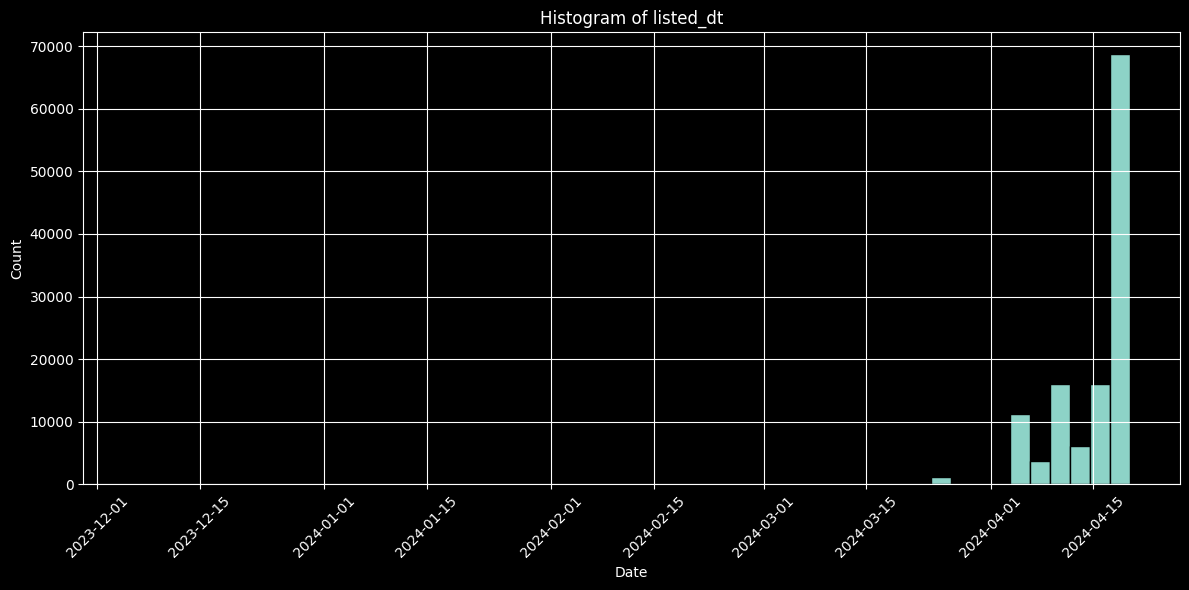

In [39]:
# Extract the year from the date for binning
plt.figure(figsize=(12, 6))
data['listed_dt'].hist(bins=50, edgecolor='black')

# Customize the plot
plt.title('Histogram of listed_dt')
plt.xlabel('Date')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

In [31]:
df['date']

0        2024-04-17 23:45:08
1        2024-04-11 17:51:27
2        2024-04-16 14:26:54
3        2024-04-12 04:23:32
4        2024-04-18 14:52:23
                 ...        
123844   2024-04-20 00:00:23
123845   2024-04-20 00:17:16
123846   2024-04-20 00:18:59
123847   2024-04-20 00:23:52
123848   2024-04-20 00:23:36
Name: date, Length: 123849, dtype: datetime64[ns]

In [19]:
import datetime

# Timestamp in milliseconds
timestamp_ms = 1.713398e+12

# Convert to seconds
timestamp_s = timestamp_ms / 1000

# Convert to datetime object
date = datetime.datetime.fromtimestamp(timestamp_s)

print(date)

2024-04-18 00:53:20


In [5]:
# Use the extract_entities function to extract the entities from the descriptions using the spacy model
parse_NERS = False
if parse_NERS:
    products, orgs, other = [], [], []
    for i, row in tqdm.tqdm(data.iterrows(), total=len(data)):
        try:
            p, o, ot = extract_entities(row['description'])
            products.append(p)
            orgs.append(o)
            other.append(ot)
        except Exception as e:
            print(e)
            products.append([])
            orgs.append([])
            other.append([])

    data['products'] = products
    data['orgs'] = orgs
    data['other'] = other

    data.products = data.products.apply(lambda x: set(x))
    data.to_feather("data/postings.fth")

In [30]:
df.to_feather("data/job_postings_with_entities.fth")

In [31]:
# Convert the product froma list with repetions to a set
# Save the data to a feather file with new NER
data = pd.read_feather("data/job_postings_with_entities.fth")

In [32]:
data.columns

Index(['job_id', 'scraped', 'company_id', 'work_type', 'formatted_work_type',
       'location', 'job_posting_url', 'applies', 'original_listed_time',
       'remote_allowed', 'application_url', 'application_type', 'expiry',
       'inferred_benefits', 'closed_time', 'formatted_experience_level',
       'years_experience', 'description', 'title', 'skills_desc', 'views',
       'job_region', 'listed_time', 'degree', 'posting_domain', 'sponsored',
       'country', 'country_code', 'job_functions', 'industry_names',
       'company_name', 'description_company', 'company_size', 'state',
       'country_company', 'city', 'zip_code', 'address', 'url', 'text',
       'entities_COMPANY', 'entities_ METHODS', 'entities_TOOLS',
       'entities_EXPERIENCE', 'entities_LEVEL', 'entities_REMOTE',
       'entities_RESPONSABILITY', 'entities_TITLE', 'entities_QUALIFICATION'],
      dtype='object')

In [33]:
data.description_company

1254348    AlliedTravelCareers is the ultimate talent mar...
1635670    JobsInLogistics.com dominates the online recru...
1156879    Established in 1836, Legal & General is one of...
1246363    LocumJobsOnline is the ultimate talent marketp...
2419261    From economic headwinds to talent complexities...
                                 ...                        
1517439    Ampcus Inc is a global technology and business...
2900991    Our mission is to improve the health and well-...
1651196    Born in 1927, Hubert James Taffin de Givenchy ...
2036811    TravelNurseSource is the ultimate talent marke...
167211     Actalent connects passion with purpose. Our sc...
Name: description_company, Length: 100000, dtype: object

In [7]:
all_products = [product for products in data.products for product in products]

In [8]:
all_products = [product for products in data.products for product in products]
pd.Series(all_products).value_counts().head(500)

Excel                 14651
Word                   9352
Office                 5677
PowerPoint             5566
Python                 5338
                      ...  
TikTok                   39
OneSite                  39
RabbitMQ                 39
SkillBridge              39
Azure SQL Database       38
Name: count, Length: 500, dtype: int64

In [9]:
# Filter down list of jobs to a more manageable size using common ML / AI keywords
keywords = [
    "machine learning",
    "data science",
    "artificial intelligence",
    "deep learning",
    "neural networks",
    "NLP",
    "natural language processing",
    "computer vision",
    "data analysis",
    "predictive modeling",
    "big data",
    "Python",
    "TensorFlow",
    "PyTorch",
    "scikit-learn",
    "Keras",
    "data engineering",
    "algorithm development",
    "data mining",
    "reinforcement learning",
    " ML ",
    " AI "
]

pattern = '|'.join(keywords)
data['contains_keyword'] = data['description'].str.contains(pattern, case=False, na=False)
data['contains_keyword'].mean()

0.08590299477589645

In [10]:
data.query('contains_keyword == True')

job_id                                       company_name  \
5         91700727                          Downtown Raleigh Alliance   
6        103254301                                         Raw Cereal   
78      2234533717                                        Ideando Inc   
86      2735151240                                   LT Apparel Group   
116     3245063922                                           Saxon AI   
...            ...                                                ...   
123797  3906263103                                 Rose International   
123803  3906263308  UAMS - University of Arkansas for Medical Scie...   
123830  3906265278                                    Associated Bank   
123831  3906265301                                               RAND   
123845  3906267126                                          Pinterest   

                                                    title  \
5                Economic Development and Planning Intern   
6                                                Producer   
78                                    Full Stack Engineer   
86                             Intern- Business Analytics   
116                                        Data Architect   
...                                                   ...   
123797                                  Software Engineer   
123803                    Research Assistant I- Pathology   
123830                             React Native Developer   
123831  Bachelor’s Level Research Assistant - Quantita...   
123845       Staff Software Engineer, ML Serving Platform   

                                              description  max_salary  \
5       Job summary:The Economic Development & Plannin...        20.0   
6       Company DescriptionRaw Cereal is a creative de...    300000.0   
78      Location: Remote\nCompany Overview:SkillFit, a...         NaN   
86      Summer Internshipadidas & Carhartt kids Divisi...         NaN   
116     Request: Data ArchitectLocation: San Francisco...         NaN   
...                                                   ...         ...   
123797  Date Posted: 04/19/2024Hiring Organization: Ro...        34.0   
123803  Current University of Arkansas System employee...         NaN   
123830  At Associated Bank we strive to create an incl...         NaN   
123831  Job Type\n\nTerm (Fixed Term)\n\nRAND is seeki...         NaN   
123845  About Pinterest:\n\nMillions of people across ...         NaN   

       pay_period                                    location  company_id  \
5          HOURLY                                 Raleigh, NC   1481176.0   
6          YEARLY                               United States  81942316.0   
78           None                               United States  69611476.0   
86           None  Greensboro--Winston-Salem--High Point Area    103060.0   
116          None                           San Francisco, CA    224935.0   
...           ...                                         ...         ...   
123797     HOURLY                               Mossville, IL     12309.0   
123803       None                             Little Rock, AR     11250.0   
123830       None                        Milwaukee County, WI      8667.0   
123831       None                              Pittsburgh, PA    165654.0   
123845       None                               United States   1124131.0   

        views  med_salary  ...  sponsored   work_type  currency  \
5         9.0         NaN  ...          0  INTERNSHIP       USD   
6         7.0         NaN  ...          0    CONTRACT       USD   
78       21.0         NaN  ...          0   FULL_TIME      None   
86        5.0         NaN  ...          0   TEMPORARY      None   
116       7.0         NaN  ...          0    CONTRACT      None   
...       ...         ...  ...        ...         ...       ...   
123797    2.0         NaN  ...          0   TEMPORARY       USD   
123803    4.0         NaN  ...          0   FULL_TIME      None 

In [11]:
data['products_str'] = data['products'].apply(lambda x: ", ".join(x))

In [34]:
#Connect to Weaviate Cluster
client = weaviate.connect_to_local(host='45.79.238.197',auth_credentials=weaviate.auth.AuthApiKey(weaviate_key))


In [35]:
columns = ['job_id','company_id','company_name','title','formatted_experience_level','job_functions', 'industry_names', 'entities_TOOLS', 'entities_ METHODS', 'entities_REMOTE', 'entities_EXPERIENCE', 'entities_RESPONSABILITY', 'description', ]

In [36]:
data[columns].head(10).to_clipboard()

In [ ]:
listings_wvc = client.collections.create(
    name="ListingsV2",
    vectorizer_config=wvc.config.Configure.Vectorizer.text2vec_openai(model='text-embedding-3-small'),    # Set the vectorizer to "text2vec-openai" to use the OpenAI API for vector-related operations
    generative_config=wvc.config.Configure.Generative.openai(),             # Set the generative module to "generative-cohere" to use the Cohere API for RAG
    properties = [
        wvc.config.Property(
            name="job_id",
            data_type=wvc.config.DataType.INT,
            description="Unique identifier for the job posting",
            skip_vectorization=True
        ),
        wvc.config.Property(
            name="company_id",
            data_type=wvc.config.DataType.INT,
            description="Unique identifier for the company",
            skip_vectorization=True
        ),
        wvc.config.Property(
            name="title",
            data_type=wvc.config.DataType.TEXT,
            description="Job Listing Title",
        ),
        wvc.config.Property(
            name="company_name",
            data_type=wvc.config.DataType.TEXT,
            description="Name of the company",
        ),
        wvc.config.Property(
            name="formatted_experience_level",
            data_type=wvc.config.DataType.TEXT,
            description="Formatted experience level for the job",
             
        ),
        wvc.config.Property(
            name="job_functions",
            data_type=wvc.config.DataType.TEXT_ARRAY,
            description="List of job functions",
             
        ),
        wvc.config.Property(
            name="industry_names",
            data_type=wvc.config.DataType.TEXT_ARRAY,
            description="List of industry names",
             
        ),
        wvc.config.Property(
            name="entities_TOOLS",
            data_type=wvc.config.DataType.TEXT_ARRAY,
            description="List of tools mentioned in the job posting",
             
        ),
        wvc.config.Property(
            name="entities_METHODS",
            data_type=wvc.config.DataType.TEXT_ARRAY,
            description="List of methods mentioned in the job posting",
             
        ),
        wvc.config.Property(
            name="entities_REMOTE",
            data_type=wvc.config.DataType.TEXT_ARRAY,
            description="List of remote work related entities",
             
        ),
        wvc.config.Property(
            name="entities_EXPERIENCE",
            data_type=wvc.config.DataType.TEXT_ARRAY,
            description="List of experience mentioned in the job posting",
             
        ),
        wvc.config.Property(
            name="entities_RESPONSABILITY",
            data_type=wvc.config.DataType.TEXT_ARRAY,
            description="List of responsibility mentioned in the job posting",
             
        ),
        wvc.config.Property(
            name="description",
            data_type=wvc.config.DataType.TEXT,
            description="Original job description text",
            skip_vectorization=True
        ),
    ]
)


In [57]:
listings_wvc = client.collections.create(
    name="ListingsV3_original",
    vectorizer_config=wvc.config.Configure.Vectorizer.text2vec_openai(model='text-embedding-3-small'),    # Set the vectorizer to "text2vec-openai" to use the OpenAI API for vector-related operations
    generative_config=wvc.config.Configure.Generative.openai(),             # Set the generative module to "generative-cohere" to use the Cohere API for RAG
    properties = [
        wvc.config.Property(
            name="job_id",
            data_type=wvc.config.DataType.INT,
            description="Unique identifier for the job posting",
            skip_vectorization=True
        ),
        wvc.config.Property(
            name="company_id",
            data_type=wvc.config.DataType.INT,
            description="Unique identifier for the company",
            skip_vectorization=True
        ),
        wvc.config.Property(
            name="title",
            data_type=wvc.config.DataType.TEXT,
            description="Job Listing Title",
        ),
        wvc.config.Property(
            name="company_name",
            data_type=wvc.config.DataType.TEXT,
            description="Name of the company",
        ),
        wvc.config.Property(
            name="formatted_experience_level",
            data_type=wvc.config.DataType.TEXT,
            description="Formatted experience level for the job",
             
        ),
        wvc.config.Property(
            name="job_functions",
            data_type=wvc.config.DataType.TEXT_ARRAY,
            description="List of job functions",
             
        ),
        wvc.config.Property(
            name="industry_names",
            data_type=wvc.config.DataType.TEXT_ARRAY,
            description="List of industry names",
             
        ),
        wvc.config.Property(
            name="description",
            data_type=wvc.config.DataType.TEXT,
            description="Original job description text",
        ),
    ]
)

In [9]:
data

job_id  scraped  company_id  work_type formatted_work_type  \
2086722  3941432101        1  37268793.0   CONTRACT            Contract   
1115459  3940376488        1      1035.0  FULL_TIME           Full-time   
213512   3939389138        1   1456380.0  FULL_TIME           Full-time   
895818   3940139406        1    581027.0  FULL_TIME           Full-time   
142020   3939313654        1   3516935.0  FULL_TIME           Full-time   
...             ...      ...         ...        ...                 ...   
1804959  3941125251        1   3516935.0  FULL_TIME           Full-time   
2363780  3941721925        1      1908.0  FULL_TIME           Full-time   
2714902  3961190853        1   5240076.0  FULL_TIME           Full-time   
1552847  3940850027        1    740371.0  FULL_TIME           Full-time   
2882802  3966736512        1   3572530.0  FULL_TIME           Full-time   

                                   location  \
2086722                     Linn County, IA   
1115459           New Mexico, United States   
213512   Liverpool, England, United Kingdom   
895818                     Coral Gables, FL   
142020                          Gresham, OR   
...                                     ...   
1804959           New Jersey, United States   
2363780                     Bloomington, MN   
2714902                          Boston, MA   
1552847                          Boston, MA   
2882802                        Columbus, OH   

                                           job_posting_url  applies  \
2086722  https://www.linkedin.com/jobs/view/3941432101/...      NaN   
1115459  https://www.linkedin.com/jobs/view/3940376488/...      2.0   
213512   https://www.linkedin.com/jobs/view/3939389138/...      NaN   
895818   https://www.linkedin.com/jobs/view/3940139406/...      1.0   
142020   https://www.linkedin.com/jobs/view/3939313654/...      NaN   
...                                                    ...      ...   
1804959  https://www.linkedin.com/jobs/view/3941125251/...      NaN   
2363780  https://www.linkedin.com/jobs/view/3941721925/...      NaN   
2714902  https://www.linkedin.com/jobs/view/3961190853/...      NaN   
1552847  https://www.linkedin.com/jobs/view/3940850027/...      NaN   
2882802  https://www.linkedin.com/jobs/view/3966736512/...     47.0   

         original_listed_time  remote_allowed  ...  \
2086722          1.717429e+12             0.0  ...   
1115459          1.717686e+12             1.0  ...   
213512           1.717162e+12             0.0  ...   
895818           1.717200e+12             0.0  ...   
142020           1.717144e+12             0.0  ...   
...                       ...             ...  ...   
1804959          1.717404e+12             0.0  ...   
2363780          1.717453e+12             1.0  ...   
2714902          1.719830e+12             0.0  ...   
1552847          1.717710e+12             1.0  ...   
2882802          1.720046e+12             0.0  ...   

                                                      text  \
2086722  Field Data Collectors | Digitive | We are seek...   
1115459  Senior Technical Program Manager, Datacenter D...   
213512   Director AI & Data Science | Jooble | **We are...   
895818   Coral Gables Data Analysis Tutor | Varsity Tut...   
142020   Senior Data Engineer - Portfolio Management Gr...   
...                                                    ...   
1804959  Manager, Software Engineering, Back End | Clic...   
2363780  Python/Linux Software Engineer | General Dynam...   
2714902  Software Development Engineer - AWS Dash Cart ...   
1552847  Data Engineer - Boston | CDC Foundation | Job ...   
2882802  Software Engineer, Data Services | Western All...   

                                            entities_TOOLS  \
2086722                                                 []   
1115459                                                 []   
213512                                                  []   
895818                                              

In [20]:
data['entities_TOOLS'].iloc[4]

array(['Tableau', 'APIs', 'Power BI', 'Tableau', 'Microsoft SQL Server',
       'NoSQL', 'C#', '.Net', 'Python', 'SQL', 'SSIS', 'Informatica',
       'Kafka', 'Spark', 'MuleSoft'], dtype=object)

In [38]:
data.rename(columns={'entities_ METHODS':'entities_METHODS'}, inplace=True)

In [39]:
data

job_id  scraped  company_id  work_type formatted_work_type  \
1254348  3940522647        1  11092369.0  FULL_TIME           Full-time   
1635670  3940943977        1     91974.0  FULL_TIME           Full-time   
1156879  3940421349        1      5459.0  FULL_TIME           Full-time   
1246363  3940514543        1  11172808.0  FULL_TIME           Full-time   
2419261  3941779467        1      2889.0  FULL_TIME           Full-time   
...             ...      ...         ...        ...                 ...   
1517439  3940812784        1    217273.0  FULL_TIME           Full-time   
2900991  3966761724        1    166587.0  FULL_TIME           Full-time   
1651196  3940961160        1     32987.0  FULL_TIME           Full-time   
2036811  3941379263        1   1358653.0  FULL_TIME           Full-time   
167211   3939340223        1  71904349.0  FULL_TIME           Full-time   

                                location  \
1254348                       Dallas, TX   
1635670                      Chicago, IL   
1156879  London, England, United Kingdom   
1246363                      Concord, NH   
2419261                       Totowa, NJ   
...                                  ...   
1517439                    San Diego, CA   
2900991                 Hillsborough, NC   
1651196                    Las Vegas, NV   
2036811                     Plymouth, MA   
167211                     Mundelein, IL   

                                           job_posting_url  applies  \
1254348  https://www.linkedin.com/jobs/view/3940522647/...      NaN   
1635670  https://www.linkedin.com/jobs/view/3940943977/...      NaN   
1156879  https://www.linkedin.com/jobs/view/3940421349/...      NaN   
1246363  https://www.linkedin.com/jobs/view/3940514543/...      NaN   
2419261  https://www.linkedin.com/jobs/view/3941779467/...      NaN   
...                                                    ...      ...   
1517439  https://www.linkedin.com/jobs/view/3940812784/...      NaN   
2900991  https://www.linkedin.com/jobs/view/3966761724/...      0.0   
1651196  https://www.linkedin.com/jobs/view/3940961160/...     37.0   
2036811  https://www.linkedin.com/jobs/view/3941379263/...      NaN   
167211   https://www.linkedin.com/jobs/view/3939340223/...      NaN   

         original_listed_time  remote_allowed  ...  \
1254348          1.717375e+12             0.0  ...   
1635670          1.717426e+12             0.0  ...   
1156879          1.717257e+12             0.0  ...   
1246363          1.717374e+12             0.0  ...   
2419261          1.717474e+12             0.0  ...   
...                       ...             ...  ...   
1517439          1.717699e+12             0.0  ...   
2900991          1.720059e+12             0.0  ...   
1651196          1.715270e+12             0.0  ...   
2036811          1.717786e+12             0.0  ...   
167211           1.717150e+12             0.0  ...   

                                                      text entities_COMPANY  \
1254348  Travel PT - $2,410 per week in Plano, TX | All...               []   
1635670  CDL-A Team Truck Driver | JobsInLogistics.com ...               []   
1156879  Junior Developer - 12 month FTC | Legal & Gene...               []   
1246363  Locum Physician (MD/DO) - Psychiatry in Hampst...               []   
2419261  Band Saw Operator | Aerotek | **Large Metal Ma...               []   
...                                                    ...              ...   
1517439  Sr. Consultant | Ampcus Inc | **Role: Sr. Cons...               []   
2900991  RN Clinical Nurse II - Acute Inpatient Rehabil...               []   
1651196  Style Advisor - Las Vegas Wynn | GIVENCHY | Gi...               []   
2036811  Travel Nurse RN - Labor/Delivery in Plymouth, ...               []   
167211   Microbiology Lab Technician | Actalent | **Des...               []   

                                          entities_METHODS  \
1254348  [Partner of the Year, Largest Patient Impact, ...   
1635670 

In [51]:
#Loading in the data into the collection by size of 100 pieces, as the data is resonbly large 
#Create a new collection called JobListings with the openAI text2vec model and gen model
#Just using autoschema here as the data is straightforward enough
weaviate_load = True
if weaviate_load:
    # listings = client.collections.create(
    #     name="JobListings",
    #     vectorizer_config=wvc.config.Configure.Vectorizer.text2vec_openai(model='text-embedding-3-small'),  # If set to "none" you must always provide vectors yourself. Could be any other "text2vec-*" also.
    #     generative_config=wvc.config.Configure.Generative.openai()  # Ensure the `generative-openai` module is used for generative queries
        
    
    listings_objs = data[['job_id','company_id','company_name','title','formatted_experience_level','job_functions', 'industry_names', 'entities_TOOLS', 'entities_METHODS', 'entities_REMOTE', 'entities_EXPERIENCE', 'entities_RESPONSABILITY', 'description', ]].fillna('').head(100_000).to_dict(orient="records")
    pprint(listings_objs[0])

    listings = client.collections.get("ListingsV2")

    for i in range(50_000,100_000,1000):
        print(i)
        # try:
        listings.data.insert_many(listings_objs[i:i+1000])
        # except Exception as e:
            # print(e)



{'company_id': 11092369.0,
 'company_name': 'AlliedTravelCareers',
 'description': 'AlliedTravelCareers is working with FlexCare Medical Staffing '
                'to find a qualified PT in Plano, Texas, 75023! Pay '
                'Information $2,410 per week About The Position FlexCare is a '
                'nationwide leader in the staffing of travel nurses and '
                'clinicians. With access to thousands of facilities around the '
                'country, our mission is to deliver premier travel staffing '
                'solutions with integrity and transparency. FlexCare’s '
                'exceptional service and reputation make it one of the most '
                'awarded healthcare staffing companies in the industry each '
                'year, ranking as one of the top travel nursing companies in '
                'the nation from industry authorities like Highway '
                'Hypodermics, Travel Nursing Central, and BluePipes. FlexCare '
            

In [59]:
#Loads in database with original description encoding without NER extraction
weaviate_load = True

if weaviate_load:

    listings_objs = data[['job_id','company_id','company_name','title','formatted_experience_level','job_functions', 'industry_names','description', ]].fillna('').head(100_000).to_dict(orient="records")
    pprint(listings_objs[0])

    listings = client.collections.get("ListingsV3_original")

    for i in range(0,10_000,100):
        print(i)
        # try:
        listings.data.insert_many(listings_objs[i:i+100])
        # except Exception as e:
            # print(e)


{'company_id': 11092369.0,
 'company_name': 'AlliedTravelCareers',
 'description': 'AlliedTravelCareers is working with FlexCare Medical Staffing '
                'to find a qualified PT in Plano, Texas, 75023! Pay '
                'Information $2,410 per week About The Position FlexCare is a '
                'nationwide leader in the staffing of travel nurses and '
                'clinicians. With access to thousands of facilities around the '
                'country, our mission is to deliver premier travel staffing '
                'solutions with integrity and transparency. FlexCare’s '
                'exceptional service and reputation make it one of the most '
                'awarded healthcare staffing companies in the industry each '
                'year, ranking as one of the top travel nursing companies in '
                'the nation from industry authorities like Highway '
                'Hypodermics, Travel Nursing Central, and BluePipes. FlexCare '
            

In [49]:
data['entities_TOOLS'] = data['entities_TOOLS'].apply(lambda x: x.tolist())
data['entities_METHODS'] = data['entities_METHODS'].apply(lambda x: x.tolist())
data['entities_REMOTE'] = data['entities_REMOTE'].apply(lambda x: x.tolist())
data['entities_EXPERIENCE'] = data['entities_EXPERIENCE'].apply(lambda x: x.tolist())
data['entities_RESPONSABILITY'] = data['entities_RESPONSABILITY'].apply(lambda x: x.tolist())



In [43]:
data['job_functions'] = data['job_functions'].apply(lambda x: eval(x))

In [47]:
data['industry_names'] = data['industry_names'].apply(lambda x: eval(x))

TypeError: eval() arg 1 must be a string, bytes or code object

In [48]:
listings_objs

[{'job_id': 3940522647,
  'company_id': 11092369.0,
  'company_name': 'AlliedTravelCareers',
  'title': 'Travel PT - $2,410 per week in Plano, TX',
  'formatted_experience_level': 'Mid-Senior level',
  'job_functions': ['Management', 'Manufacturing'],
  'industry_names': ['Hospitals and Health Care'],
  'entities_TOOLS': array(['BluePipes.', 'BluePipes.'], dtype=object),
  'entities_METHODS': ['Partner of the Year, Largest Patient Impact, and Most Engaged Travel Associate.'],
  'entities_REMOTE': [],
  'entities_EXPERIENCE': [],
  'entities_RESPONSABILITY': [],
  'description': "AlliedTravelCareers is working with FlexCare Medical Staffing to find a qualified PT in Plano, Texas, 75023! Pay Information $2,410 per week About The Position FlexCare is a nationwide leader in the staffing of travel nurses and clinicians. With access to thousands of facilities around the country, our mission is to deliver premier travel staffing solutions with integrity and transparency. FlexCare’s exceptiona

In [45]:
#Quick test of some query functionailty

# 

target_client = weaviate.connect_to_local(host='45.79.238.197',auth_credentials=weaviate.auth.AuthApiKey(weaviate_key))
target_client.connect()
reviews_tgt = target_client.collections.get("ListingsV2")
response = reviews_tgt.query.near_text(
    query = ["Machine Learning"],
    # move_away=Move(force=1, concepts="Creative Industries"),
    move_to=Move(force=1, concepts="Finance"),
    return_metadata=[
            "creation_time",
            "last_update_time",
            "distance",
            "certainty",
            "score",
            "explain_score",
            "is_consistent",
        ],
    limit=1,

)
print(response.objects[0].uuid)
print(response.objects[0].properties['title'])
print(response.objects[0].properties['company_name'])
pprint(response.objects[0].properties['description'])
print(response.objects[0].properties['job_id'])
pprint(response.objects[0].properties['products_str'])

C:\Users\Nick\AppData\Local\Temp\ipykernel_15204\2026664619.py:7: ResourceWarning: unclosed <socket.socket fd=5764, family=2, type=1, proto=0, laddr=('192.168.1.68', 56116), raddr=('45.79.238.197', 8080)>
  reviews_tgt = target_client.collections.get("ListingsV2")


27a69776-a2ec-4aee-b5be-0ba3b5213fba
Senior Data Scientist - Credit Risk Analytics
Jooble
('**We are promoting this job opportunity as provided by a third party, the '
 'employer. In case of your interest in this job opportunity and for more '
 'details please click on "Apply" button below, which will take you to the '
 "employer's website\n"
 '\n'
 '**\n'
 '\n'
 '\n'
 '** Senior Data Scientist - Credit Risk Analytics \n'
 '\n'
 '**\n'
 '\n'
 '\n'
 'Hybrid in London / Remote within the UK\n'
 '\n'
 '**The Company\n'
 '\n'
 '**\n'
 '\n'
 '\n'
 'Fast, flexible finance empowers small businesses to manage their cash flow '
 'better and seize opportunities - making their business and the economy '
 'stronger as a whole. At iwoca, we do just that. We help businesses get the '
 'funds they need, when they need it, often within minutes. We’ve already made '
 'several billion in funding available to more than 100,000 businesses since '
 'we launched in 2012, and positioned ourselves as a leadin

KeyError: 'products_str'

In [61]:
item_details = {}
test = ''
for item in listings.iterator(include_vector=True):
    item_details[item.properties['job_id']] = {'uuid': item.uuid, 'embedding': item.vector['default']}

In [62]:
data_1k = data[data.job_id.isin(list(item_details.keys()))].copy()
data_1k.columns

Index(['job_id', 'scraped', 'company_id', 'work_type', 'formatted_work_type',
       'location', 'job_posting_url', 'applies', 'original_listed_time',
       'remote_allowed', 'application_url', 'application_type', 'expiry',
       'inferred_benefits', 'closed_time', 'formatted_experience_level',
       'years_experience', 'description', 'title', 'skills_desc', 'views',
       'job_region', 'listed_time', 'degree', 'posting_domain', 'sponsored',
       'country', 'country_code', 'job_functions', 'industry_names',
       'company_name', 'description_company', 'company_size', 'state',
       'country_company', 'city', 'zip_code', 'address', 'url', 'text',
       'entities_COMPANY', 'entities_METHODS', 'entities_TOOLS',
       'entities_EXPERIENCE', 'entities_LEVEL', 'entities_REMOTE',
       'entities_RESPONSABILITY', 'entities_TITLE', 'entities_QUALIFICATION'],
      dtype='object')

In [63]:
data_1k['vector'] = data_1k['job_id'].apply(lambda x: item_details[x]['embedding'])
data_1k['wv_uuid'] = data_1k['job_id'].apply(lambda x: str(item_details[x]['uuid']))

In [64]:
x = str(data_1k['wv_uuid'].iloc[0])

In [24]:
data_1k.to_feather("data/postings_w_embeddings_v2_original.fth")


In [7]:
data_new = pd.read_feather("data/postings_w_embeddings_v2.fth")
data_1k = pd.read_feather("data/postings_w_embeddings_v2_original.fth")

In [10]:
data_new_w_annotations = data_new.merge(df[['job_id','annotations']], on='job_id', how='left')

In [23]:
data_new_w_annotations.to_feather("data/postings_w_embeddings_v2.fth")

In [5]:
data_original = data_1k.copy()

In [6]:
new_old = pd.merge(data_new, data_original, on='job_id', suffixes=('_new', '_original'))

In [7]:
import numpy as np

In [8]:
new_old['distance'] = new_old.apply(lambda x: 1- np.dot(x['vector_new'], x['vector_original'])/(np.linalg.norm(x['vector_new'])*(np.linalg.norm(x['vector_original']))), axis=1)

In [9]:
new_old['distance'].describe()

count    9955.000000
mean        0.249027
std         0.056584
min         0.046437
25%         0.210149
50%         0.245103
75%         0.286986
max         0.535568
Name: distance, dtype: float64

In [11]:
new_old.query('job_id == 3939391171').description_new.values[0] 

'**We are promoting this job opportunity as provided by a third party, the employer. In case of your interest in this job opportunity and for more details please click on "Apply" button below, which will take you to the employer\'s website\n\n**\n\n\nThe Yellowknives Dene First Nation (YKDFN) is governed by a Chief and Council which has offices in Dettah and Ndilo. The YKDFN Chiefs and Council affirm our sacred obligation to serve our people and our commitment to live balanced contemporary lifestyles with culture and traditions important to our community, to speak our traditional language and to protect our natural resources and treaty rights. For Chiefs and Council to lead the YKDFN requires having qualified personnel to achieve a prosperous future for our citizens. The incumbent works within this context to provide effective and efficient level of support and assistance. Apply to HR@ykdene.com by closing date of June 4, 2024. ** Responsibilities \n\n**\n\n\nReporting to the Finance D

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
from ast import literal_eval


matrix = np.array(data_1k['vector'].to_list())

In [ ]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(1000, 2)

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

matrix = np.array(data_1k['vector'].to_list())
n_clusters = 4

kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42)
kmeans.fit(matrix)
data_1k['Cluster'] = kmeans.labels_

c:\Users\Nick\.conda\envs\weaviate\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



In [ ]:
data_1k['python'] = data_1k['prodcuts_str'].str.contains("Pytorch", case=False, na=False)
data_1k['python_int'] = data_1k['python'].astype(int)
data_1k['ml'] = data_1k['title'].str.contains("Machine Learning", case=False, na=False).astype(int)

26

Text(0.5, 1.0, 't-SNE of Job Postings')

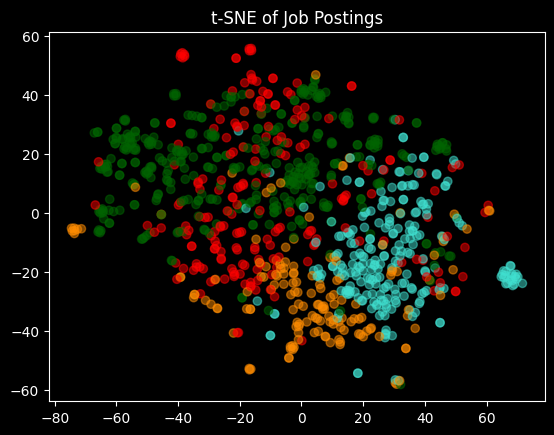

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]
x,y = vis_dims.T.tolist()

# x,y,z = vis_dims.T
# color_indices = df.Score.values - 1
color_indices = data_1k['Cluster'].values

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y,c=color_indices, cmap=colormap, alpha=0.5)

plt.title("t-SNE of Job Postings")

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.offline import plot
# Assuming df is your DataFrame and it has columns 'tsne-2d-one', 'tsne-2d-two' and 'title'
fig = go.Figure(data=go.Scatter(
    x=x,
    y=y,
    # z=z,
    mode='markers',
    marker=dict(
        size=8,
        color=data_1k['Cluster'],  # set color to cluster values
        colorscale='Viridis',  # choose a colorscale
        opacity=0.8
    ),
    # marker=dict(size=8, opacity=0.5),
    text=data_1k['title']+' | '+data_1k['company_name'],  # this will set the hover text
    hoverinfo='text',
    
))

fig.update_layout(title='t-SNE plot',
                  xaxis=dict(title='Dimension 1'),
                  yaxis=dict(title='Dimension 2'),
                  hovermode='closest')

fig.show()

plot(fig)

'temp-plot.html'

In [ ]:
from openai import OpenAI
import os

client = OpenAI(api_key=os.environ.get("OPENAI_APIKEY", "<your OpenAI API key if not set as env var>"))

# Reading a review which belong to each group.
rev_per_cluster = 10

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        data_1k[data_1k.Cluster == i]
        .description
        .sample(rev_per_cluster, random_state=42)
        .values
    )

    messages = [
        {"role": "user", "content": f'What do the following job listings have in common?\n\nListings:\n"""\n{reviews}\n"""\n\nTheme:'}
    ]

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0)
    print(response.choices[0].message.content.replace("\n", ""))

    sample_cluster_rows = data_1k[data_1k.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.title.values[j], end=" | ")
        print(sample_cluster_rows.company_name.values[j], end="  |  ")
        print(sample_cluster_rows.products_str.str[:70].values[j])

    print("-" * 100)

Cluster 0 Theme: All of the job listings are related to recruitment, staffing, or human resources. They involve roles such as Growth Analyst, Human Resources Generalist, Supply Planner, Healthcare Analytic Consultant, Director of Finance, Materials Manager, Marketing Intern, Project Manager, Buyer Assistant, and National Recruiter. These listings all focus on aspects
Growth Specialist | Augment Jobs  |  Python, Mixpanel, SQL
Human Resources Generalist | California Health Care Foundation  |  Excel
Supply Chain Analyst - Consumer Goods | WhiteCap Search  |  Excel
Lead Analytic Consultant, Analytics | apree health  |  SAS, Gitlab, Analytics, Advanced Primary Care, Airflow, Mixpanel, a Go
Financial Director | GC Recruitment  |  
Senior Materials Manager | Whitaker Technical  |  Excel, Access
Marketing Intern (Canada) | Ardent Mills  |  
Project Manager | Just Whole Care  |  Agile
Assistant Buyer | JADE DRUG COMPANY, INC  |  Excel
Healthcare Recruiter | Planet Healthcare  |  
--------------

In [13]:
#Starting on companies and their products
companies = pd.read_csv("data/companies/companies.csv")
company_industries = pd.read_csv("data/companies/company_industries.csv")
comapny_specialties = pd.read_csv("data/companies/company_specialities.csv")
company_employee_counts  = pd.read_csv("data/companies/employee_counts.csv")

In [28]:
comapny_specialties = comapny_specialties.groupby('company_id').agg({'speciality': lambda x: list(x)}).reset_index()

In [22]:
company_industries = company_industries.groupby('company_id').agg({'industry': lambda x: list(x)}).reset_index()

In [26]:
company_industries.industry.value_counts()

industry
[Staffing and Recruiting]                                   2386
[IT Services and IT Consulting]                             2127
[Hospitals and Health Care]                                 1672
[Software Development]                                      1438
[Financial Services]                                         985
                                                            ... 
[Alternative Dispute Resolution]                               1
[Manufacturing, Retail Apparel and Fashion]                    1
[Real Estate, Financial Services]                              1
[Staffing and Recruiting, IT Services and IT Consulting]       1
[Retail, Personal Care Product Manufacturing]                  1
Name: count, Length: 154, dtype: int64

In [30]:
comapnies_data = companies.merge(company_industries, on="company_id", how="left")
comapnies_data = comapnies_data.merge(comapny_specialties, on="company_id", how="left")
# comapnies_data = comapnies_data.merge(company_employee_counts, on="company_id", how="left")

In [35]:
comapnies_data = comapnies_data[comapnies_data['description'].notna()]
comapnies_data

company_id                                        name  \
0            1009                                         IBM   
1            1016                               GE HealthCare   
2            1025                  Hewlett Packard Enterprise   
3            1028                                      Oracle   
4            1033                                   Accenture   
...           ...                                         ...   
24466   103456527  Kinder Prep Montessori Nursery & Preschool   
24467   103458790                       Leon S. Avakian, Inc.   
24469   103466352                      Centent Consulting LLC   
24470   103467540           Kings and Queens Productions, LLC   
24471   103468936                                    WebUnite   

                                             description  company_size  \
0      At IBM, we do more than work. We create. We cr...           7.0   
1      Every day millions of people feel the impact o...           7.0   
2      Official LinkedIn of Hewlett Packard Enterpris...           7.0   
3      We’re a cloud technology company that provides...           7.0   
4      Accenture is a leading global professional ser...           7.0   
...                                                  ...           ...   
24466  Explore our renowned daycare and preschool cen...           1.0   
24467  Avakian Engineering works to provide the most ...           1.0   
24469  Centent Consulting LLC is a reputable human re...           NaN   
24470  We are a small but mighty collection of thinke...           NaN   
24471  Our mission at WebUnite is to offer experience...           NaN   

              state country              city zip_code  \
0                NY      US  Armonk, New York    10504   
1                 0      US           Chicago        0   
2             Texas      US           Houston    77389   
3             Texas      US            Austin    78741   
4                 0      IE          Dublin 2        0   
...             ...     ...               ...      ...   
24466      New York      US          Brooklyn    11249   
24467             0       0                 0        0   
24469             0       0                 0        0   
24470             0       0                 0        0   
24471  Pennsylvania      US       Southampton    18966   

                                     address  \
0      International Business Machines Corp.   
1                                          -   
2                1701 E Mossy Oaks Rd Spring   
3                            2300 Oracle Way   
4                        Grand Canal Harbour   
...                                      ...   
24466                            49 Broadway   
24467                                      0   
24469                                      0   
24470                                      0   
24471                    720 2nd Street Pike   

                                                     url  \
0                   https://www.linkedin.com/company/ibm   
1          https://www.linkedin.com/company/gehealthcare   
2      https://www.linkedin.com/company/hewlett-packa...   
3                https://www.linkedin.com/company/oracle   
4             https://www.linkedin.com/company/accenture   
...                                                  ...   
24466  https://www.linkedin.com/company/kinder-prep-m...   
24467  https://www.linkedin.com/company/leon-s-avakia...   
24469  https://www.linkedin.com/company/centent-consu...   
24470  https://www.linkedin.com/company/kings-and-que...   
24471          https://www.linkedin.com/company/webunite   

                                            industry  \
0                    [IT Services and IT Consulting]   
1                        [Hospitals and Health Care]   
2                    [IT Services and IT Consulting]   
3                    [IT Services and IT Consulting]   
4                 [Business Consulting and Services]   
...   

In [40]:
from langchain_community.llms import Ollama
llm = Ollama(model="llama3")
llm.invoke("Why is the sky blue?")

"A classic question!\n\nThe sky appears blue because of a phenomenon called Rayleigh scattering, named after the British physicist Lord Rayleigh. He was the first to explain why the sky is blue in 1871.\n\nHere's what happens:\n\nWhen sunlight enters Earth's atmosphere, it encounters tiny molecules of gases like nitrogen (N2) and oxygen (O2). These molecules are much smaller than the wavelength of light, which is typically measured in nanometers (nm).\n\nThe shorter wavelengths of light, such as violet and blue (around 400-500 nm), are scattered more strongly by these small molecules. This scattering effect is known as Rayleigh scattering.\n\nAs a result:\n\n1. The shorter wavelengths of light (blue and violet) are distributed evenly throughout the sky, reaching our eyes from all directions.\n2. The longer wavelengths of light (red and orange, around 600-700 nm), which are less affected by Rayleigh scattering, continue to travel in a straight line, reaching our eyes only from the direc

In [89]:
def comp_summarization_prompt(company):
    prompt = f"""Please generate a dictionary containing the following information about the company based on the provided company listing and other information you have accesable: {company}

    Do not speak in first person, and do not include any personal opinions or biases. The information should be objective and factual.

1. "Summary": A 300-word summarization of the company, including its main products or services, target market, and any notable achievements or unique selling points.

2. "industry": The primary industry or sector the company operates in, such as "Technology", "Finance", "Healthcare", etc.

3. "common_roles": A list of common job roles or positions typically found in the company, such as "Software Engineer", "Marketing Manager", "Financial Analyst", etc.

4. "specialization": The company's main area of expertise or specialization within its industry.

5. "ML/AI": Classify this comapny if it is related to in any means AI/ML Technology

If you can't find relevant info in the listing provided, search your own data.

Return response in JSON format"""
    return prompt

In [80]:
test = comapnies_data[['name', 'description', 'industry', 'speciality']].iloc[2].to_dict()

In [85]:
test_prompt = comp_summarization_prompt(test)
test_prompt

'Please generate a dictionary containing the following information about the company based on the provided company listing and other information you have accesable: {\'name\': \'Hewlett Packard Enterprise\', \'description\': \'Official LinkedIn of Hewlett Packard Enterprise, the global edge-to-cloud company. Sharing our passion and purpose through technology and innovation. \', \'industry\': [\'IT Services and IT Consulting\'], \'speciality\': nan}\n\n    Do not speak in first person, and do not include any personal opinions or biases. The information should be objective and factual.\n\n1. "Summary": A 300-word summarization of the company, including its main products or services, target market, and any notable achievements or unique selling points.\n\n2. "industry": The primary industry or sector the company operates in, such as "Technology", "Finance", "Healthcare", etc.\n\n3. "common_roles": A list of common job roles or positions typically found in the company, such as "Software En

In [94]:
result = llm.invoke('What does IBM specialized in?')

In [95]:
result 


"IBM (International Business Machines) is a multinational technology company that has a wide range of specialties and expertise. Some of the areas where IBM has specialized over the years include:\n\n1. Computing Hardware: IBM is known for its mainframe computers, which are powerful machines used by many organizations to store and process large amounts of data.\n2. Data Processing: IBM has been a leader in data processing and storage solutions, including cloud-based services like IBM Cloud and IBM Storage.\n3. Artificial Intelligence (AI): IBM has made significant investments in AI research and development, offering tools and services for building intelligent systems, such as Watson, an AI platform that uses natural language processing and machine learning to answer questions.\n4. Blockchain: IBM has developed blockchain solutions for various industries, including supply chain management, financial services, and healthcare.\n5. Cybersecurity: IBM offers a range of cybersecurity solutio

In [93]:
pprint(result, width=140)

('Here is the generated dictionary in JSON format:\n'
 '\n'
 '```\n'
 '{\n'
 '  "name": "Hewlett Packard Enterprise",\n'
 '  "description": "Official LinkedIn of Hewlett Packard Enterprise, the global edge-to-cloud company. Sharing our passion and purpose '
 'through technology and innovation.",\n'
 '  "industry": ["IT Services and IT Consulting"],\n'
 '  "summary": "Hewlett Packard Enterprise is a leading provider of edge-to-cloud solutions, offering a range of products and services '
 "that enable customers to drive digital transformation. The company's portfolio includes servers, storage, networking, software-defined "
 'infrastructure, and more. HPE serves a broad range of industries, including healthcare, finance, retail, and government, with a focus on '
 "helping organizations solve complex IT challenges. Notable achievements include being named one of the world's most innovative companies "
 'by Fast Company, and receiving recognition for its commitment to sustainability.",\n'


In [ ]:
# Use the extract_entities function to extract the entities from the descriptions using the spacy model
products, orgs, other = [], [], []
for i, row in tqdm.tqdm(comapnies_data.iterrows(), total=len(data)):
    try:
        p, o, ot = extract_entities(row['description'])
        products.append(p)
        orgs.append(o)
        other.append(ot)
    except Exception as e:
        print(e)
        products.append([])
        orgs.append([])
        other.append([])

comapnies_data['products'] = products
comapnies_data['orgs'] = orgs
comapnies_data['other'] = other

comapnies_data.to_feather("data/companies_complete.fth")

comapnies_wv = client.collections.create(
    name="Comapnies",
    vectorizer_config=wvc.config.Configure.Vectorizer.text2vec_openai(model='text-embedding-3-small'),  # If set to "none" you must always provide vectors yourself. Could be any other "text2vec-*" also.
    generative_config=wvc.config.Configure.Generative.openai()  # Ensure the `generative-openai` module is used for generative queries
    
)
companies_data = comapnies_data[comapnies_data['company_id'].isin(data['company_id'])]

comapnies_data['products_str'] = comapnies_data['products'].apply(lambda x: ", ".join(x))

companies_objs = data[["comapny_id","company_name","description","industry","speciality","employee_count","follower_count",'products_str']].fillna('').head(100_000).to_dict(orient="records")
pprint(listings_objs[0])

listings = client.collections.get("Comapnies")
# listings.data.insert_many(listings_objs)

listings.data.insert_many(companies_objs)